# Signal Processing Dummy Data Example

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Build a neural network that a list of floats.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from operator import add
import random
from math import ceil, floor
import pydot
import graphviz

Generate lists of numbers. Half have a spike, half don't. Those with the spike we label as "slam".

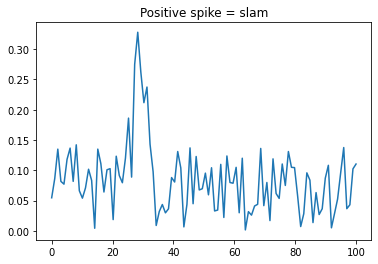

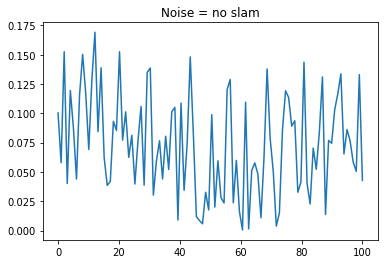

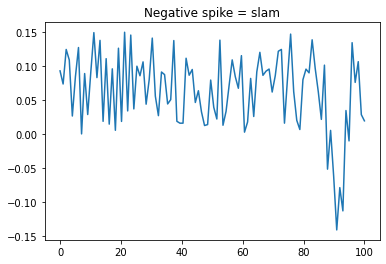

In [52]:
def generate_sample(slamStdDev: 2, inverted: False):
    loc = 100 * np.random.rand(1)
    std = abs(slamStdDev)
    x = np.linspace(start=0, stop=100, num=100)
    y = stats.norm.pdf(x, loc, std)
    z = np.zeros(100)
    r = np.random.rand(100)
    return list(map(add, r * 0.15, -1*y if inverted else y)) 

def make_y(positives, negatives):
    y = np.full((positives + negatives, 1), [1])

    for idx, val in enumerate(y):
        if idx > positives:
            y[idx] = [0]

    return y

x = np.linspace(start=0, stop=100, num=100)

# Plot with sharp spike

plt.plot(x, generate_sample(2, False))
plt.title('Positive spike = slam')
plt.show()

# Plot with wide spike
plt.plot(x, generate_sample(10, False))
plt.title('Noise = no slam')
plt.show()

# Plot with negative spike
plt.plot(x, generate_sample(2, True))
plt.title('Negative spike = slam')
plt.show()

Create 10000 positive spikes, 10000 negative spikes and 20000 non-spikes.

In [28]:
slams = [generate_sample(2, False) for i in range(10000)] + [generate_sample(2, True) for i in range(10000)]
non_slams = [generate_sample(20, False) for i in range(10000)] + [generate_sample(20, True) for i in range(10000)]

random.shuffle(slams)
random.shuffle(non_slams)

training_pct = 0.8

train_slams = slams[0:floor(len(slams)*training_pct)]
train_non_slams = non_slams[0:floor(len(non_slams)*training_pct):]
x_train = np.asarray(train_slams + train_non_slams)
y_train = make_y(len(train_slams), len(train_non_slams))

test_slams = slams[-ceil(len(slams)*(1-training_pct)):]
test_non_slams = non_slams[-ceil(len(non_slams)*(1-training_pct)):]
x_test = np.asarray(test_slams + test_non_slams)
y_test = make_y(len(test_slams), len(test_non_slams))


print("All slams: ", len(slams))
print("All non slams: ", len(non_slams))

print("Positive training samples: ", len(train_slams))
print("Negative training samples: ", len(train_non_slams))
print("All training Xs: ", len(x_train))
print("All training Ys: ", len(y_train))

print("Positive test samples: ", len(test_slams))
print("Negative test samples: ", len(test_non_slams))
print("All test Xs: ", len(x_test))
print("All test Ys: ", len(y_test))

All slams:  20000
All non slams:  20000
Positive training samples:  16000
Negative training samples:  16000
All training Xs:  32000
All training Ys:  32000
Positive test samples:  4000
Negative test samples:  4000
All test Xs:  8000
All test Ys:  8000


Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [53]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='relu', input_shape=(100,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1),
])

tf.keras.utils.plot_model(model, "model.png")

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 20,301
Trainable params: 20,301
Non-trainable params: 0
_________________________________________________________________


Now we compile the model. No idea if this is the corret optimizer, metrics or loss function. We're shooting in the dark here. Let's test the model outputs. We're expecting total noise from both the slam and non-slam predictions beause the model hasn't been fit. 


Model output shape
    Result counts: 16000 (slam) 
                   16000 (non-slam)
    Result shape:  1



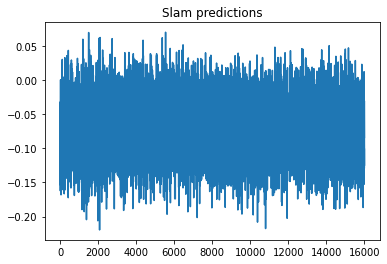

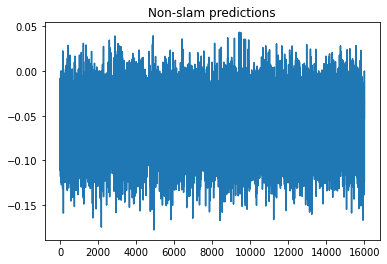

In [36]:
slam_predictions = model.predict(train_slams)
non_slam_predictions = model.predict(train_non_slams)

x = np.linspace(start=0, stop=16000, num=16000)

print("""
Model output shape
    Result counts: {} (slam) 
                   {} (non-slam)
    Result shape:  {}
""".format(len(slam_predictions), len(non_slam_predictions), len(slam_predictions[0])))
# Plot with sharp spike

plt.plot(x, slam_predictions)
plt.title('Slam predictions')
plt.show()

plt.plot(x, non_slam_predictions)
plt.title('Non-slam predictions')
plt.show()


The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [45]:

print("X training samples: ", len(x_train))
print("Y training samples: ", len(y_train))
print(y_train)

model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=2)

X training samples:  32000
Y training samples:  32000
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0049 - mae: 0.0206
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0050 - mae: 0.0201
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0047 - mae: 0.0194
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0044 - mae: 0.0184
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0042 - mae: 0.0181
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0041 - mae: 0.0175
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0040 - mae: 0.0170
Epoch 8/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0037 - mae: 0.0160
Epoch 9/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0038 - mae: 0.0163
Epoch 10/10
1000/1000 [==============

The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [46]:
model.evaluate(x_test,  y_test, verbose=2)

250/250 - 0s - loss: 0.0073 - mae: 0.0188


[0.0073142885230481625, 0.01880929246544838]

The image classifier is now trained to ~99% accuracy on this dataset.

Model output shape


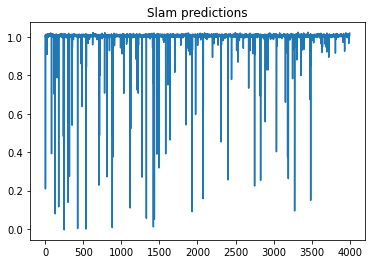

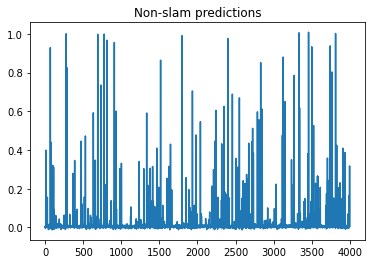

In [47]:
slam_predictions = model.predict(test_slams)
non_slam_predictions = model.predict(test_non_slams)
all_predictions = slam_predictions + non_slam_predictions

x = np.linspace(start=0, stop=len(all_predictions), num=len(all_predictions))

print("Model output shape")

plt.plot(x, slam_predictions)
plt.title('Slam predictions')
plt.show()

plt.plot(x, non_slam_predictions)
plt.title('Non-slam predictions')
plt.show()

Alternative optimizer:

In [48]:
print("Adam optimizer and accuracy")

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='relu', input_shape=(100,)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss="mse", metrics=["accuracy"])

print("X training samples: ", len(x_train))
print("Y training samples: ", len(y_train))
print(y_train)

model.fit(x_train, y_train, epochs=10)


Adam optimizer and accuracy
X training samples:  32000
Y training samples:  32000
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0844 - accuracy: 0.8954
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0134 - accuracy: 0.9862
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0082 - accuracy: 0.9904
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0070 - accuracy: 0.9917
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0066 - accuracy: 0.9917
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 0.9938
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0056 - accuracy: 0.9929
Epoch 8/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0042 - accuracy: 0.9948
Epoch 9/10
1000/1000 [==============================] - 1s 1ms/ste

Model output shape


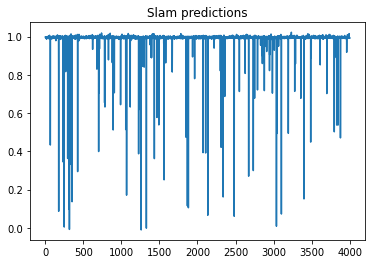

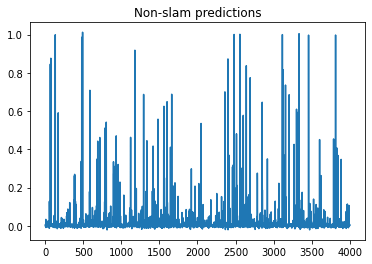

In [49]:
slam_predictions = model.predict(test_slams)
non_slam_predictions = model.predict(test_non_slams)
all_predictions = slam_predictions + non_slam_predictions

x = np.linspace(start=0, stop=len(all_predictions), num=len(all_predictions))

print("Model output shape")

plt.plot(x, slam_predictions)
plt.title('Slam predictions')
plt.show()

plt.plot(x, non_slam_predictions)
plt.title('Non-slam predictions')
plt.show()

In [50]:
model.evaluate(x_test,  y_test, verbose=2)

250/250 - 0s - loss: 0.0069 - accuracy: 0.9911


[0.006925318855792284, 0.9911249876022339]